# Free-Throw Prediction
Ryan Halvorson, Advisor: Demba Ba

In [157]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input STYLE="color: #4286f4" type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Abstract


This thesis presents a wearable device to predict free-throw shots in basketball. Faster knowledge of shot success could enable more efficient motor skill development for shooters. The designed system analyzes muscular activation and physical motion of the arm to enable nearly instantaneous shot prediction and feedback. Binary state-space models track shot probability within shot sequences. After supervised learning, preliminary models achieve predictive accuracies of up to 81% with areas under the receiver operating characteristic curve of 0.64. Further quantitative analyses reveal characteristics of successful and unsuccessful shots to inform shooters’ techniques. This device is an unobtrusive, low-cost, wearable solution for basketball players looking to improve their technique.

## Motivation


In the game of basketball, players seek to score points by shooting a ball through a hoop. After being fouled, a player is given the opportunity to shoot two uncontested free-throws from a line 13 feet in front of the basket. As many games come down to only one or two points, free-throws become critical to the success of a team. As a result, players spend many hours throughout their careers developing skills at shooting free-throws. However, despite many new teaching methods and increased practice, the NBA League average for free throw shooting has remained roughly the same for the last 70 years. One limit to improving shot techniques is the absence of accessible, robust, and immediate feedback in free-throw shooting.

# Device Design


A wearable arm sleeve was designed as shown below. Accelerometers are attached to the hand and arm. EMG sensors are attached to the biceps, triceps, and carpi radialis using disposable adhesive patches. Wires are tucked or hidden in the sleeve to minimize interference.


![alt text](thesis_schematic012517.png "Schematic")


# System Overview


![alt text](system.png "Schematic")

# Signal Analysis

### Import Packages

In [8]:
import IPython
print "IPython version:      %6.6s (need at least 1.0)" % IPython.__version__
import numpy as np
print "Numpy version:        %6.6s (need at least 1.7.1)" % np.__version__
import scipy as sp
from scipy import signal
print "SciPy version:        %6.6s (need at least 0.12.0)" % sp.__version__
import pandas as pd
print "Pandas version:       %6.6s (need at least 0.11.0)" % pd.__version__
import matplotlib
%matplotlib inline 
print "Mapltolib version:    %6.6s (need at least 1.2.1)" % matplotlib.__version__
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set_style("white")
sns.set_context('poster')
sns.set_style("ticks")

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 4)

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

IPython version:       5.1.0 (need at least 1.0)
Numpy version:        1.12.0 (need at least 1.7.1)
SciPy version:        0.17.1 (need at least 0.12.0)
Pandas version:       0.18.1 (need at least 0.11.0)
Mapltolib version:     1.5.1 (need at least 1.2.1)
Populating the interactive namespace from numpy and matplotlib


/Users/Ryan/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['tri', 'f', 'rc']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Load Dataset of Shots

In [13]:
import csv
with open('/Users/Ryan/Desktop/ES100hf/prototype3/dan_werner/dan_werner.csv', 'rb') as f:
    rawData = list(csv.reader(f))
    data = np.array(rawData).astype(np.float) #store as array "data"[1:]

t = data[:,12]
t -= t[0]

# EMG sensors
fcr = data[:,0]
bic = data[:,1]
tri = data[:,2]

# shoulder ACC
sx = pylab.demean(data[:,3])
sy = pylab.demean(data[:,4])
sz = pylab.demean(data[:,5])

s_mag = np.sqrt(sx**2+sy**2+sz**2)

# hand 9DoF
hx = pylab.demean(data[:,6])
hy = pylab.demean(data[:,7])
hz = pylab.demean(data[:,8])
hgx = pylab.demean(data[:,9])
hgy = pylab.demean(data[:,10])
hgz = pylab.demean(data[:,11])

h_mag = np.sqrt(hx**2+hy**2+hz**2)

min_range = 80
max_range = 0
window_size = min_range + max_range
time2 = np.linspace(0,window_size-1,window_size)/108.
aligned_data = np.zeros((np.size(shots), window_size, 14))
for i in range(np.size(shots)):
    aligned_data[i,:,0] = h_mag[(shots[i]-min_range):(shots[i]+max_range)]
    aligned_data[i,:,1] = s_mag[(shots[i]-min_range):(shots[i]+max_range)]
    aligned_data[i,:,2] = fcr[(shots[i]-min_range):(shots[i]+max_range)]
    aligned_data[i,:,3] = tri[(shots[i]-min_range):(shots[i]+max_range)]
    aligned_data[i,:,4] = bic[(shots[i]-min_range):(shots[i]+max_range)]
    aligned_data[i,:,5] = hx[(shots[i]-min_range):(shots[i]+max_range)]
    aligned_data[i,:,6] = hy[(shots[i]-min_range):(shots[i]+max_range)]
    aligned_data[i,:,7] = hz[(shots[i]-min_range):(shots[i]+max_range)]
    aligned_data[i,:,8] = hgx[(shots[i]-min_range):(shots[i]+max_range)]
    aligned_data[i,:,9] = hgy[(shots[i]-min_range):(shots[i]+max_range)]
    aligned_data[i,:,10] = hgz[(shots[i]-min_range):(shots[i]+max_range)]
    aligned_data[i,:,11] = sx[(shots[i]-min_range):(shots[i]+max_range)]
    aligned_data[i,:,12] = sy[(shots[i]-min_range):(shots[i]+max_range)]
    aligned_data[i,:,13] = sz[(shots[i]-min_range):(shots[i]+max_range)]

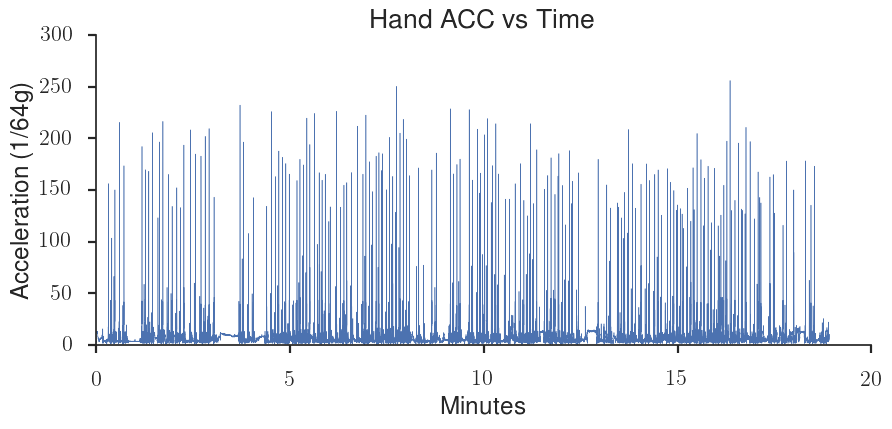

In [21]:
plt.plot(t[:120000]/60000, h_mag[:120000], linewidth=.4)
# plt.plot(t,hgx,t,hgy,t,hgz)
plt.xlabel('Minutes')
plt.title('Hand ACC vs Time')
plt.ylabel('Acceleration (1/64g)')
sns.despine()
plt.show()

## Shot Recognition (Match Filtering)


Shots are recognized onboard the arduino by convoluting a template shot with the complete dataset as follows.

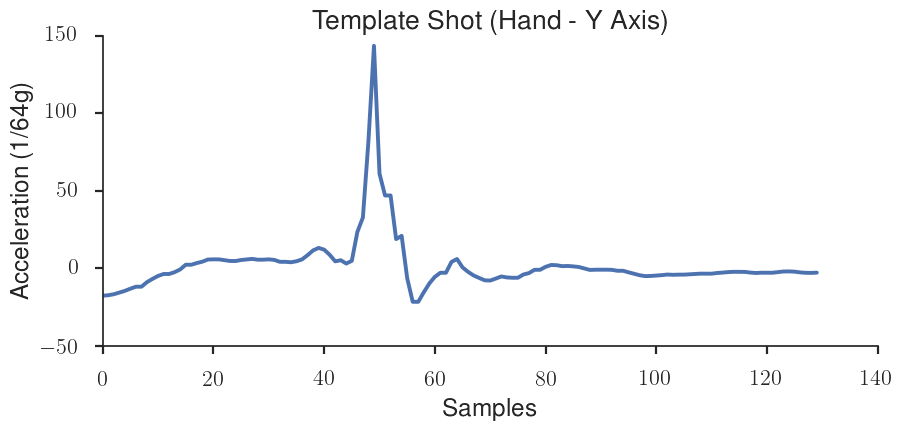

In [25]:
plt.plot(hy[86660:86790])
plt.title('Template Shot (Hand - Y Axis)')
plt.ylabel('Acceleration (1/64g)')
plt.xlabel('Samples')
sns.despine()
plt.show()

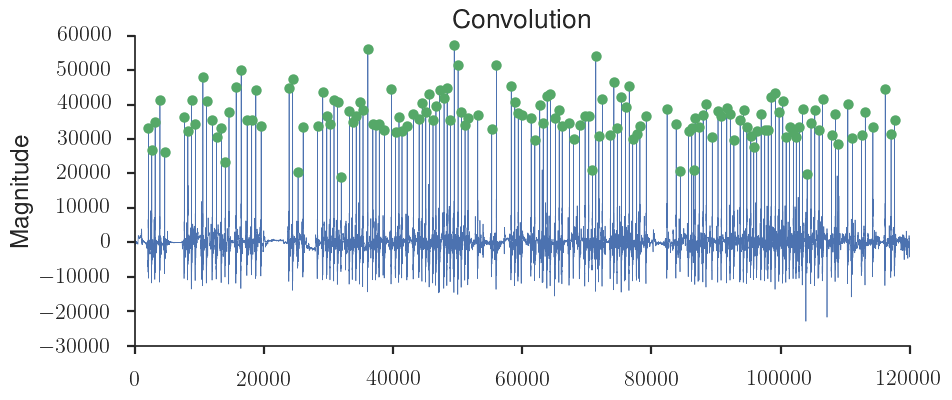

Number of shots: 150


In [49]:
ss = hy[86660:86790]

Z = np.convolve(ss,hy[:120000])

import peakutils
shots = peakutils.indexes(Z, thres=.5, min_dist=200)  
axis_font = {'fontname':'Arial', 'size':'26'}
plt.plot(Z,lw = .5)
plt.plot(shots,Z[shots],'.',markersize=15)
plt.xlim([0,120000])
plt.ylabel('Magnitude')
plt.title('Convolution')
sns.despine()
plt.show()

print "Number of shots:", np.size(shots)

## Lining up Shots


Having identified the location of each shot within the data, we can line up the shots to begin looking at patterns.

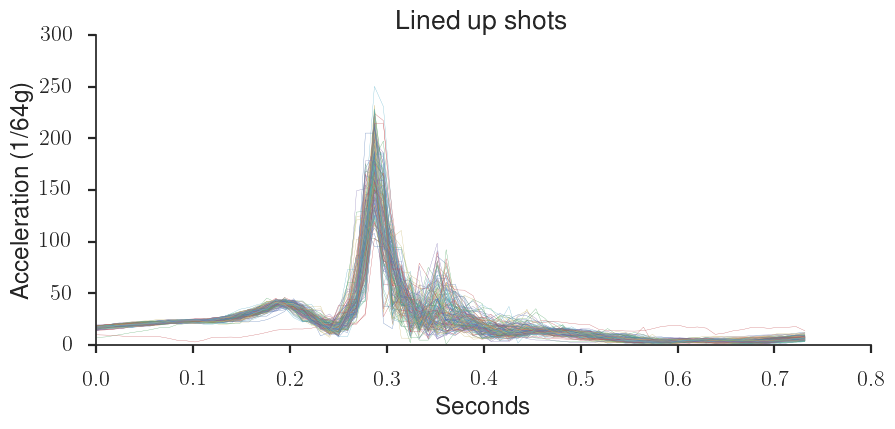

In [50]:
min_range = 80
max_range = 0
window_size = min_range + max_range

time2 = np.linspace(0,window_size-1,window_size)/108.
# i = 2
for i in range(np.size(shots)):
    plt.plot(time2, h_mag[(shots[i]-min_range):(shots[i]+max_range)], linewidth = .2)
    plt.title('Lined up shots')
    plt.xlabel('Seconds')
    plt.ylabel('Acceleration (1/64g)')
sns.despine()
plt.show()

# Shot Characterization


Knowing where to look for the shots, we can now characterize the musclular activation and acceleration of the arm throughout each shot.


![alt text](poster_characterization.png "Shot Characterization")

## Feature Engineering


Now that the shots have been identified, we can begin to look for features that distinguish "makes" from "misses".

In [106]:
with open('/Users/Ryan/Desktop/ES100hf/prototype3/dan_werner/shot_success.csv', 'rb') as f:
    rawData = list(csv.reader(f))
    suc_data = np.array(rawData).astype(np.float) #store as array "data"[1:]

ti = np.array(range(150))
makes = [i for i in range(len(suc_data)) if suc_data[i] == 1]
misses = [i for i in range(len(suc_data)) if suc_data[i] == 0]

### Plot Confidence Intervals around Shots by Class

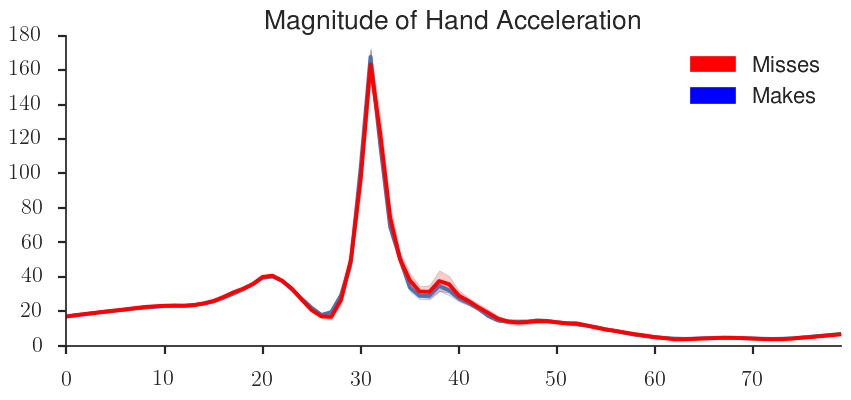

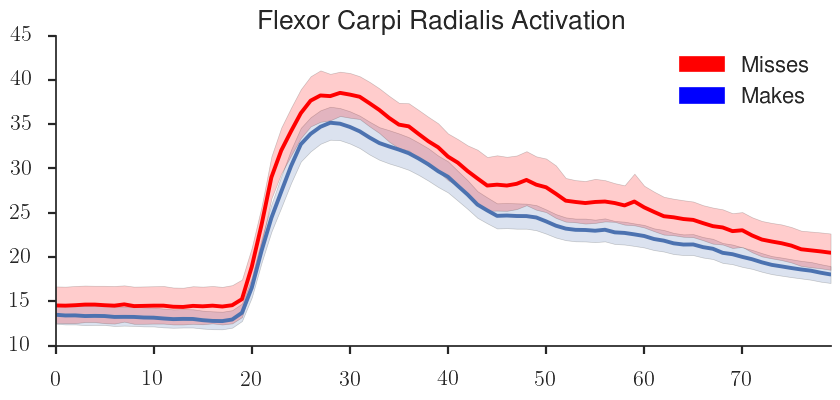

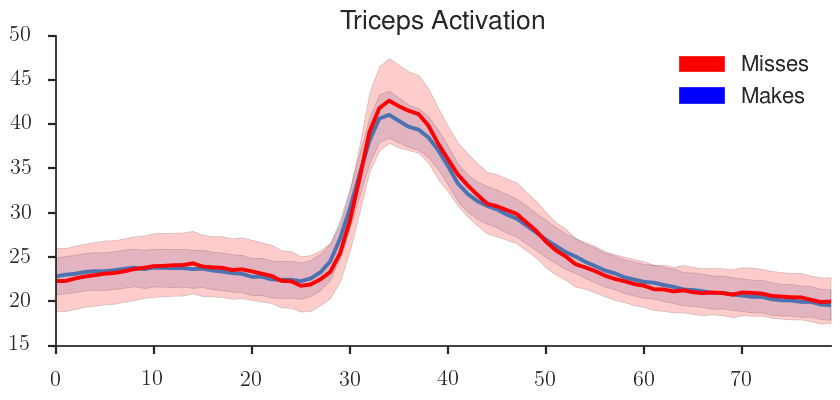

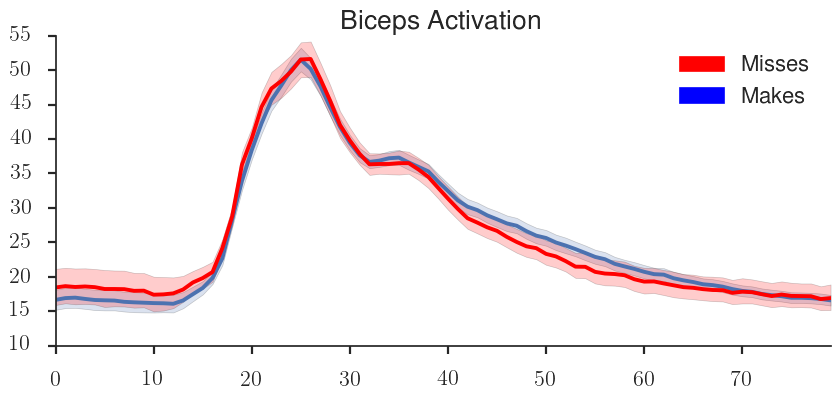

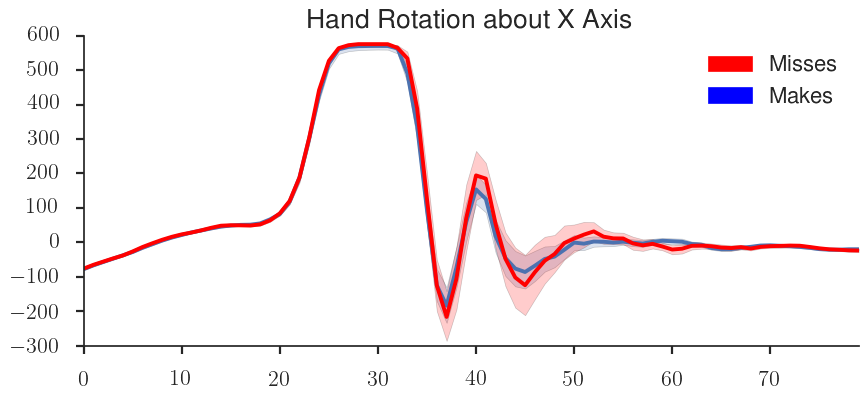

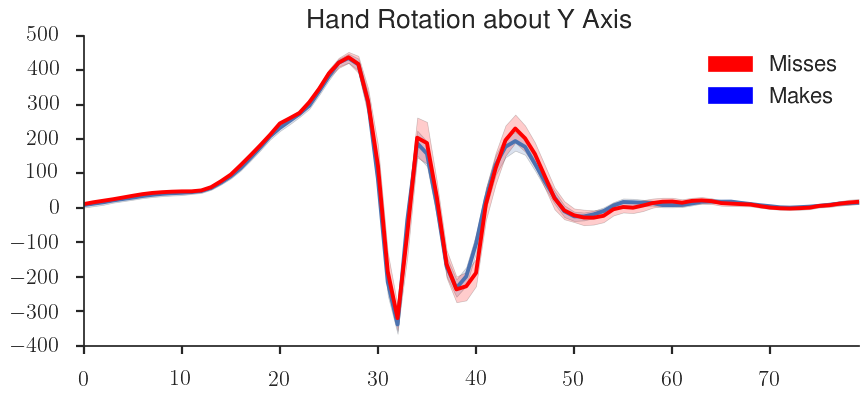

In [107]:
import matplotlib.patches as mpatches
labels = ['Magnitude of Hand Acceleration', 's magnitude', 'Flexor Carpi Radialis Activation', 'Triceps Activation', 'Biceps Activation', 'hx', 'hy', 'hz', 'Hand Rotation about X Axis', 'Hand Rotation about Y Axis', 'Hand Rotation about Z Axis']
for i in [0, 2, 3, 4,8, 9]:
    ax = sns.tsplot(data=aligned_data[makes,:,i], ci=[90])#, linewidth = 1)
    plt.title(labels[i])
    ax2 = sns.tsplot(data= aligned_data[misses,:,i], ci=[90], color = 'red')#, linewidth = 1)
    red_patch = mpatches.Patch(color='red', label='Misses')
    blue_patch = mpatches.Patch(color='blue', label='Makes')
    plt.legend(handles=[red_patch, blue_patch])
    sns.despine()
    plt.show()

## Feature Extraction


Features such as peak heights, distances, and areas under curves were analyzed to find distinguishing elements between the two shot classes.

In [108]:
feats = np.zeros((shots.size, 31))

for s in range (np.size(shots)):
    feats[s,0] = np.trapz(aligned_data[s,:,2],time2) #integrated fcr usage
    feats[s,1] = max(aligned_data[s,:,3]) #peak tricep 
    feats[s,2] = max(aligned_data[s,:,2]) #peak fcr
    feats[s,3] = max(aligned_data[s,:,6]) #peak hy
    feats[s,4] = aligned_data[s,:,3][59] # last tric
    feats[s,5] = max(aligned_data[s,:,11]) #peak sx 
    feats[s,6] = max(aligned_data[s,:,12]) #peak sx 
    feats[s,7] = np.argmax(aligned_data[s,:,3]) - np.argmax(aligned_data[s,:,2]) #distance between tricep, fcr peak
    feats[s,8] = np.argmax(aligned_data[s,:,0]) - np.argmax(aligned_data[s,:,2]) #distance between ACC mag, fcr peak
    feats[s,9] = np.argmax(aligned_data[s,:,5]) - np.argmax(aligned_data[s,:,6])
    feats[s,10] = max(aligned_data[s,:,4]) #peak bicep
    feats[s,11],feats[s,13] = np.polyfit(np.linspace(30,33,3), aligned_data[s,30:33,5], 1)
    feats[s,12], feats[s,14] = np.polyfit(np.linspace(25,30,5), aligned_data[s,25:30,2], 1)
    feats[s,15], feats[s,16] = np.polyfit(np.linspace(25,35,10), aligned_data[s,25:35,3], 1)
    feats[s,17] = aligned_data[s,35+np.argmax(aligned_data[s,35:,8]),8] ##hgx 2nd peak
    feats[s,18] = aligned_data[s,40+np.argmax(aligned_data[s,40:,8]),8] ##hgx second pesk
    feats[s,19] = aligned_data[s,32+np.argmax(aligned_data[s,32:,9]),9] ## hy stuff
    feats[s,20] = aligned_data[s,40+np.argmax(aligned_data[s,40:,9]),9] ## hy stuff
    feats[s,21] = np.argmax(aligned_data[s,35:,8])
    feats[s,22] = np.argmax(aligned_data[s,32:,9])
    feats[s,23] = np.argmax(aligned_data[s,40:,8])
    feats[s,24] = np.argmax(aligned_data[s,40:,9])
    feats[s,25] = np.trapz(aligned_data[s,35:50,8],np.linspace(35,50,15))
    feats[s,26] = np.trapz(aligned_data[s,35:50,9],np.linspace(35,50,15))
    feats[s,27] = aligned_data[s,27,2]
    feats[s,28] = aligned_data[s,42,9]
    feats[s,29] = aligned_data[s,43,9]
    feats[s,30] = aligned_data[s,42,8]


### Preprocessing


The feature matrix was pre-processed to have 0 mean and variance 1. 

In [109]:
from sklearn import preprocessing
sc_feats = preprocessing.scale(feats)

## Class Conditional Feature Distribution

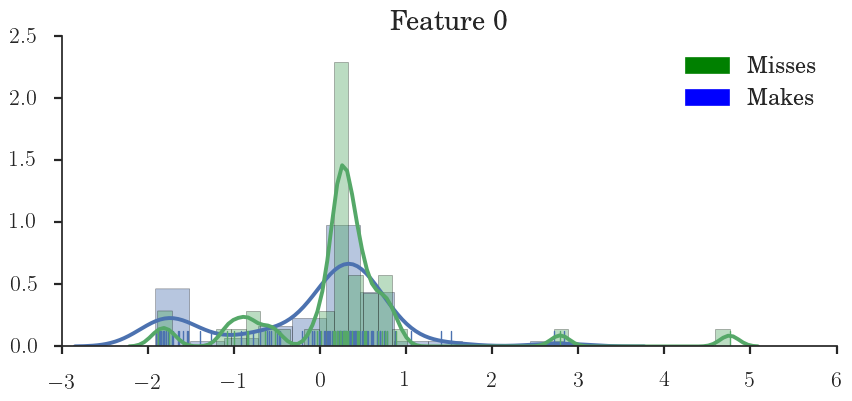

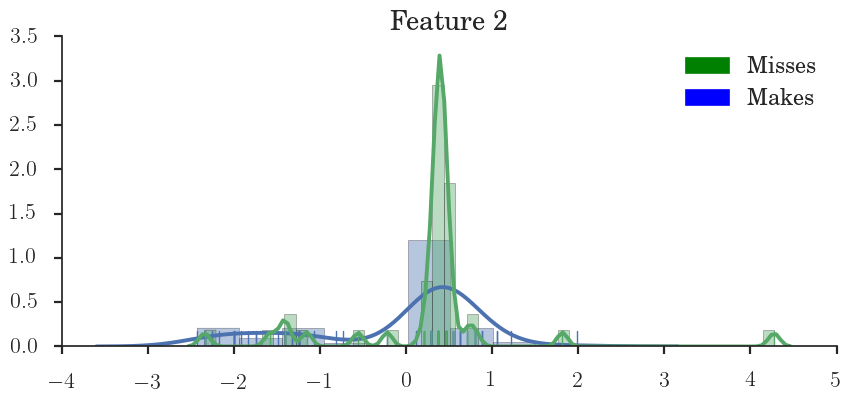

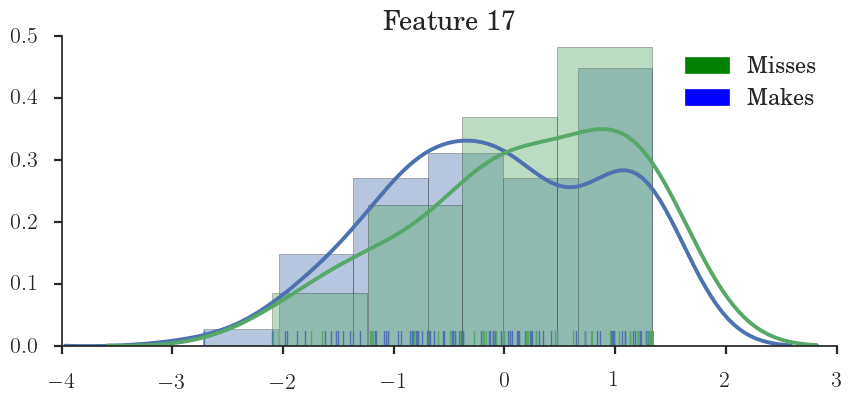

In [156]:
for i in [0,2,17]:
    sns.distplot(sc_feats[makes,i], rug=True)
    sns.distplot(sc_feats[misses,i], rug=True)
    red_patch = mpatches.Patch(color='green', label='Misses')
    blue_patch = mpatches.Patch(color='blue', label='Makes')
    plt.legend(handles=[red_patch, blue_patch])
    sns.despine()
    plt.title('Feature %d' %i)
    plt.show()

## Supervised Learning

Using the features extracted above as input, we can now train statistical models to classify the success of shots.

In [143]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
    
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Results


Models were evaluated using 6-fold Cross Validation

In [145]:
sucr = suc_data[:]
model_name = ['Ridge Regression', 'Linear Regression', 'Random Forest (500 trees)', 'Random Forest (100 trees)', 'k-NN (5 neighbors)']
clfs = [RidgeClassifier(alpha=10000, class_weight={0:2.5, 1:1}), linear_model.LinearRegression(),RandomForestClassifier(n_estimators = 500, class_weight={0:2.5, 1:1}), RandomForestClassifier(n_estimators = 100, class_weight={0:2.5, 1:1}), KNeighborsClassifier(n_neighbors=5)]  
for j in range(len(clfs)):
    scores = cross_val_score(clfs[j], sc_feats, sucr.ravel(), cv=6)
    print("%s Accuracy: %0.2f%% (%0.2f%%)" % (model_name[j], scores.mean()*100, scores.std()*100)) 

# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(64, input_dim=31, init='normal', activation='relu'))
    model.add(Dense(64, init='normal', activation='relu'))
    model.add(Dense(1, init='normal', activation='softmax')) #sigmoid
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, nb_epoch=100, batch_size=5, verbose=0)
results = cross_val_score(estimator,sc_feats, suc_data.astype(int), cv=6)
print("Neural Network: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Ridge Regression Accuracy: 67.82% (9.84%)
Linear Regression Accuracy: -63.04% (18.12%)
Random Forest (500 trees) Accuracy: 68.62% (7.93%)
Random Forest (100 trees) Accuracy: 67.35% (12.28%)
k-NN (5 neighbors) Accuracy: 69.37% (4.15%)
Neural Network: 72.67% (9.64%)


## Temporal Shot Probability

Statistical modeling lends insight into the time dependent variability in player performance. Using this model, we can tell when a shooter might be performing above or below his average.

In [146]:
def NewtonSolve(x_prior, sigma_prior, N, Nmax, mu):
    '''
    Solve for posterior mode using Newton's method
    '''
    xp = x_prior
    sp = sigma_prior

    it = xp + sp*(N - Nmax*np.exp(mu+xp)/(1.0 + np.exp(mu+xp)))     #starting iteration  

    for i in range(30): 
        g     = xp + sp*(N - Nmax*np.exp(mu+it)/(1.0+np.exp(mu+it))) - it;
        gprime = -Nmax*sp*np.exp(mu+it)/(1.0+np.exp(mu+it))**2.0 - 1.0   
        x = it  - g/gprime 

        if np.abs(x-it)<1e-10:
            return x
        it = x

    #if no value found try different ICs: needed if there are consec same values
    it = -1
    for i in range(30): 
        g     = xp + sp*(N - Nmax*np.exp(mu+it)/(1.0+np.exp(mu+it))) - it
        gprime = -Nmax*sp*np.exp(mu+it)/(1.0+np.exp(mu+it))**2.0 - 1.0
        x = it  - g/gprime 

        if np.abs(x-it)<1e-10:
            return x
        it = x

    #if no value found try different ICs
    it = 1
    for i in range(30): 
        g     = xp + sp*(N - Nmax*np.exp(mu+it)/(1+np.exp(mu+it))) - it
        gprime = -Nmax*sp*np.exp(mu+it)/(1+np.exp(mu+it))**2 - 1.0
        x = it  - g/gprime 

        if np.abs(x-it)<1e-10:
            return x
        it = x

In [147]:
def filtering(sigma, init_theta,init_sigma, N = None):
    
    
    T = len(N)# Number of history 
    theta_i = init_theta #initiate theta_0
    sigma_i = init_sigma  #initiate signma_0
    p_i = np.exp(theta_i)/(1.+np.exp(theta_i))
    theta_f = [theta_i]
    sigma_f = [sigma_i]
    p_f = [p_i]

    #iterate to calculate theta_f and sigma_f
    for i in range(1,T+1):

        sigma_i = 1./(N[i-1]*np.exp(theta_i)/(1.+np.exp(theta_i))**2 + 1./(sigma_i + sigma)) #update sigma_i

        theta_i  = NewtonSolve(theta_f[i-1],sigma_f[i-1] + sigma,N[i-1],1,0)

        p_i = np.exp(theta_i)/(1.+np.exp(theta_i)) 

        theta_f.append(theta_i)
        sigma_f.append(sigma_i)
        p_f.append(p_i)

    return theta_f,sigma_f,p_f

In [148]:
def smoothing(sigma, theta_f,sigma_f, length):
    
    T = length# Number of history
    theta_i = theta_f[-1] #initiate theta_0
    sigma_i = sigma_f[-1] #initiate signma_0
    theta_s = [theta_i]
    sigma_s = [sigma_i]
    As = []
    
    for i in range(T):
        A = sigma_f[T-i-1]/(sigma_f[T-i-1] + sigma)
        As.append(A)
        theta_i = theta_f[T-i-1] + A * (theta_i - theta_f[T-i-1])
        sigma_i = sigma_f[T-i-1] + A ** 2 * (sigma_i - sigma_f[T-i-1] - sigma)
        
        theta_s.append(theta_i)
        sigma_s.append(sigma_i)
      
    return theta_s[::-1], sigma_s[::-1], theta_f, sigma_f, As[::-1]

In [149]:
def MSTEP(xnew, signewsq, A):
    '''
    M step of EM
    '''
   
    T          = len(xnew)
    xnewt      = xnew[2:T]
    xnewtm1    = xnew[1:T-1]
    signewsqt  = signewsq[2:T]
    A          = A[1:T-1]
    covcalc    = np.multiply(signewsqt,A)

    term1      = np.dot(xnewt,xnewt) + np.sum(signewsqt)
    term2      = np.sum(covcalc) + np.dot(xnewt,xnewtm1)

    term3      = 2*xnew[1]*xnew[1] + 2*signewsq[1]
    term4      = xnew[T-1]**2 + signewsq[T-1]

    newsigsq   = (2*(term1-term2)+term3-term4)/T

    return newsigsq

In [150]:
def EM(sigma0, init_theta, init_sigma, N = None):
    
    
    
    T = len(N)# Number of history
    sigma_old = 100000
    sigma_new = sigma0
    n = 0
    p_lows = [] #skip the initial value 0 for plotting
    p_highs = []
    max_ite = 0 

    #set stopping condition for EM iterations
    while abs(sigma_old - sigma_new) > 0.00001 and max_ite < 3000:     
        max_ite += 1
        n += 1 
        sigma_old = sigma_new
        theta_f,sigma_f,_ = filtering(sigma_old,init_theta, init_sigma, N = N) #filter
        theta_s, sigma_s, theta_f, sigma_f, A  = smoothing(sigma_old,theta_f,sigma_f,len(N))#smoother
        sigma_new = MSTEP(theta_s, sigma_s, A) #EM new sigma

        #update initial conditions for filter
        init_theta = theta_s[0]
        init_sigma = sigma_s[0]


    #get the filtering result of converged EM sigma
    theta_EM,sigma_EM,p_EM = filtering(sigma_new,init_theta, init_sigma,N = N) 
    print "EM Sigma2 for BSSM: ",sigma_new

    #get the 95% confidence interval of every latent variable and corresponding p
    for theta, sigma in zip(theta_EM,sigma_EM)[1:]: #skip the initial values (0,0)

        samples = np.random.normal(theta, sigma, 10000)
        ps = map(lambda x: np.exp(x)/(1. + np.exp(x)),samples)
        p_low, p_high = np.percentile(ps,[2.5,97.5])
        p_lows.append(p_low)
        p_highs.append(p_high)

    return p_EM[1:], p_lows, p_highs, sigma_new

In [151]:
def plot_EM(N = None):
    p,p_low,p_up,_= EM(sigma0 = 0.05,init_theta=0.00, init_sigma=0.05, N = N)
    #plot ratings by week
    fig,ax = plt.subplots(1,1,figsize = (20,5))
    line_1, = ax.plot(range(len(p)),p,c = 'b',label = 'BSSM_p') #estimated hidden state
    ax.fill_between(range(len(p)),p_low, p_up,color='blue',alpha=0.2)
    blue_patch = mpatches.Patch(color='blue', alpha = 0.4,label='Uncertainty')
#     ax.legend(loc = 4,handles=[line_1, blue_patch])
    ax.set_ylim(0,1)
    ax.set_xlim(0,len(p) - 1)
#     ax.set_ylabel('Estimated Probability',fontsize=15)
#     ax.set_xlabel('n',fontsize=20)
#     ax.set_title('Estimated Probability by Shots',fontsize=25,fontweight='bold')
    sns.despine()

EM Sigma2 for BSSM:  0.086422615128


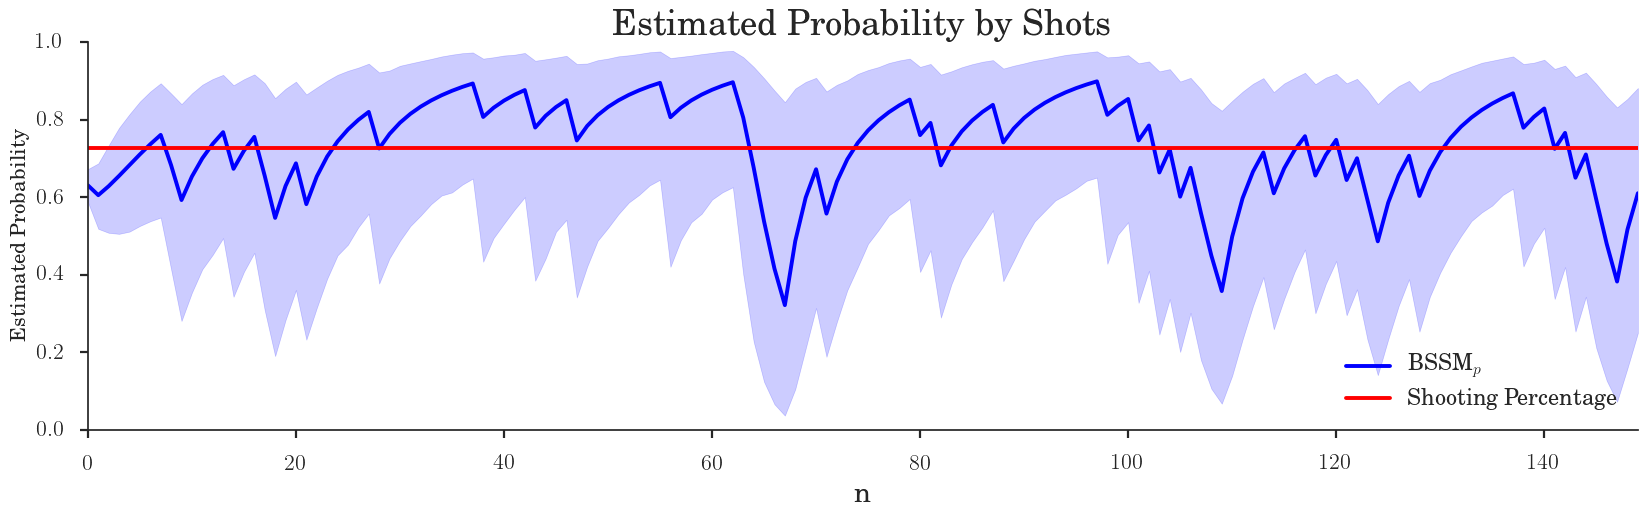

In [155]:
plot_EM(sucr.ravel())
cum_p_makes = np.ones(150)
cum_p_makes = cum_p_makes * np.sum(sucr.ravel())/np.shape(sucr.ravel())[0]
plt.plot(cum_p_makes, 'r', label = 'Shooting Percentage')
plt.legend(loc = 4)
plt.ylabel('Estimated Probability',fontsize=15)
plt.xlabel('n',fontsize=20)
plt.title('Estimated Probability by Shots',fontsize=25,fontweight='bold')
plt.figsize = (5,3)
plt.show()